<a href="https://colab.research.google.com/github/rajivsam/interactive_tutorials/tree/master/notebooks/graph_retail_EDA_I.ipynb." target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
!git clone https://github.com/rajivsam/interactive_tutorials.git
!rsync -av interactive_tutorials/notebooks/data  interactive_tutorials/notebooks/img ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.6.9.5
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle

In [2]:
! wc -l data/online_retail_II.csv

541911 data/online_retail_II.csv


# Overview

Graph analytics can useful in the analysis of retail data. This series of notebook will explore the utility of ideas from graph analytics to analyze data from an online retail store. The store has many infrequent shoppers and a group of loyal shoppers who make purchases at the store often. This study focusses on the group of loyal customers. This group has several attractive features that make it a good candidate to analyze. It is the group for which we have sufficient data describing their shopping behavior. It is also a group that is profitable from business standpoint. They generate revenue for the store. Understanding the shopping preferences of this group can help create better shopping expereiences at the store. See [this article](https://medium.datadriveninvestor.com/why-consumer-behavior-analysis-is-so-relevant-to-the-ecommerce-business-8f49c250ca9c), for example, for some of the reasons why understanding consumer behavior is important in the retail industry. Ideas from graph analytics can be applied to capture critical aspects of customer behavior and product purchase behavior that can leveraged for profit. Extracting analytical insights from the data require, the at the very least, the following:
1. Identification of a set of analytical tools that can help extract these insights.
2. Transformation of the raw data to a representation that is required by these analytical tools.

Graph analytics can be leveraged for the first task. This requires representing the customer purchases at the store in the form of a graph. A particular type of graph structure, a _bi-partite_ graph, is a particularly useful graph representation to extract insights about customer purchasing behavior at the store. Data analysis tools can be leveraged for the second task. The first two notebooks in this series will focus on the data analysis tasks. The next two notebooks will focus on the application of graph analytic tools to extract insights about customer behavior.
The data that is analyzed in this series of notebooks are transactions from the store. The data is available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II). A schematic illustrating the methodology that will be used in this series of posts is shown below 

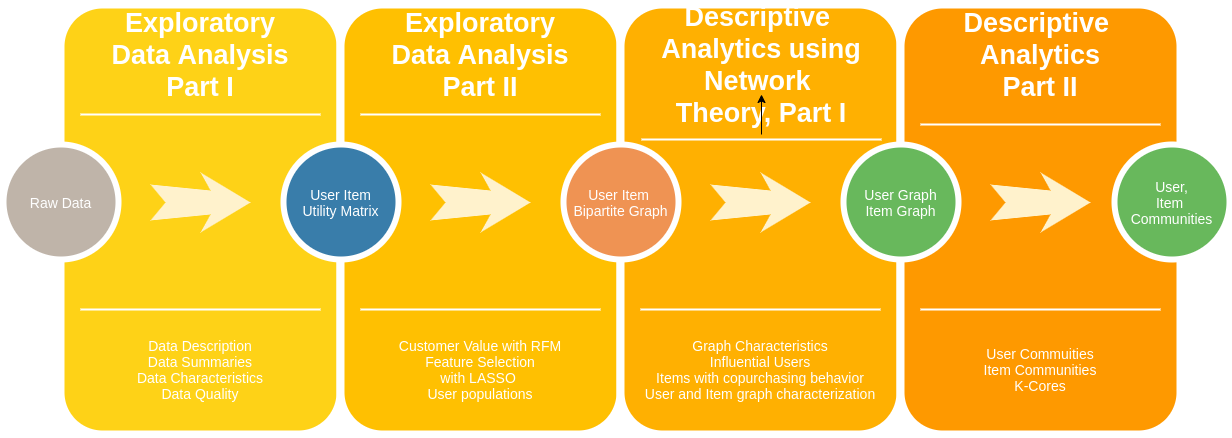

In [3]:
from IPython.display import Image
Image('img/analysis_methodology.png')

Consistent with the approach discussed above, the implementation of the notebooks follows a four-step approach. The first two steps illustrate the characteristics of the data and transform the raw data to a form where we can apply graph analytics. The last two steps illustrate the application of ideas from graph analytics to extract insights about customer purchase behavior. The schematic consists of four blocks. The title of each block captures the main functional idea performed by that block. Key features and ideas captured by a functional block are mentioned in the list at the bottom of the block. The representation of the data changes as we work through this four-step process. The circular block elements capture the nature of the data as we work through this process.

## Data Description

In [4]:
import pandas as pd
fp = "data/online_retail_II.csv"
df = pd.read_csv(fp)

## List Attributes and Data Types

In [5]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

### Description of Attributes
1. Stockcode: Identifies the goods that are sold at the store. 
2. Quantity: What kind of counts are associated with purchases.
3. Price: Identifies the price of an item.  
4. Country: Identifies the country the customer is from.
5. Customer ID: Identifies a customer.
6. Invoice date: Date of purchase.
7. Invoice: Identifies an invoice.
8. Description: The description of a stock item.

## Data Cleaning
These actions prepare the data for further analysis, performing the following:
1. Converting attribute types to the correct format where required. In this case, converting the __InvoiceDate__ attribute from string to a datetime type will facilitate downstream analysis based on summaries by time. Customer ID is a float, we will convert this to an integer.
2. Removing canceled transactions (documentation with the dataset mention that these transactions are associated with either a 'C' or "BANK" prefix in the `Invoice` column)
3. Removing transactions with missing data
4. Remove transactions where the price for an item is listed as zero

These are guidelines from the dataset description and published work by the contributors of this dataset
https://link.springer.com/article/10.1057/dbm.2012.17

As we clean the data, facts about data quality are logged. Actions that capture data quality capture are tagged with a __Data Quality Metric__ tag

### Convert InvoiceDate to `datetime`

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


### Data Quality Metrics

### Row Count

In [7]:
raw_dataset_number_of_rows = df.shape[0]
num_rows_summ = "Number of rows in the raw dataset: %d" %(raw_dataset_number_of_rows)
num_rows_summ

'Number of rows in the raw dataset: 541910'

### Data Quality Metrics

### Cancelled Transactions

In [8]:
df_c = df[df['Invoice'].str.startswith("C")]
df_bank = df[df['StockCode'].str.startswith("BANK")]
num_cancelled_returns = df_c.shape[0] + df_bank.shape[0]
cancelled_return_summ = "Cancelled or bank transactions: %d"%(num_cancelled_returns)
cancelled_return_summ

'Cancelled or bank transactions: 9325'

### Remove Cancelled Transactions

In [9]:
df = df[-df['Invoice'].str.startswith("C")]
df = df[-df['StockCode'].str.startswith("BANK")]


### Data Quality Metric

### Missing Values
Now we check to see if any values are null. If there are null values the shape will report the number of values that are null and column index.



In [10]:
df_na = df[pd.isnull(df).any(axis=1)]
df_na.shape

(134697, 8)

We now know at least one column contains null values but the previous statement only stores the first column found. 

Let's see how many fields have null values and the number of null values per field.

In [11]:
col_names = df.columns.tolist()
missing_val_summ = {}
for c in col_names:
    num_missing = df[c].isna().sum()
    missing_summ = "Column %s had %d missing values!" %(c, num_missing)
    missing_val_summ[c] = num_missing
    print(missing_summ)

Column Invoice had 0 missing values!
Column StockCode had 0 missing values!
Column Description had 1454 missing values!
Column Quantity had 0 missing values!
Column InvoiceDate had 0 missing values!
Column Price had 0 missing values!
Column Customer ID had 134697 missing values!
Column Country had 0 missing values!


### Remove Transactions with Missing Data
Note: It appears that the store has both registered and unregistered customers. Unregistered customers do not have the Customer ID attribute in the transaction record. This analysis is confined to transactions of registered store customers. A small number of store items do not have the description field. These are excluded from the transactions as well. In summary, the transaction data is limited to activities of registered customers and products with descriptions available

In [12]:
df = df.dropna(how ='any')
df["Customer ID"] = df["Customer ID"].astype(int)

### Data Quality Metric

### Zero Price

Some items have zero price. These transaction line items are dropped

In [13]:
dfp0 = df[df["Price"] == 0]
zero_price_items = dfp0.shape[0]
zero_price_item_msg = "%d items have zero price value" % (zero_price_items)
zero_price_item_msg

'40 items have zero price value'

### Remove Transactions with zero value for Price

In [14]:
df = df[df["Price"] > 0]

## Data Quality Summary

In [15]:
dqm = {}
dqm['missing_values'] = missing_val_summ
dqm['zero_price'] = zero_price_items
dqm['cancelled_bank_transactions'] = num_cancelled_returns
# log with arangopipe

## Data Characteristics

### Derived Attribute, ItemTotal
The raw dataset lists the price and the quantiy for each line item, but does not provide a item total which is the product of price and quantity. This attribute is critical in analyzing the purchasing behavior observed at the store. This derived attribute is created

In [16]:
df["ItemTotal"] = df["Price"] * df["Quantity"]

### Number of Customers

In [17]:
num_customers = len(df["Customer ID"].unique())
num_cust_msg = "Number of customers: %d" %(num_customers)
num_cust_msg

'Number of customers: 4337'

### Country of Customer Origin
This store has customers from a variety of countries. An overwhelming majority of the customers are from the UK. The analysis will be restricted to customers from the UK

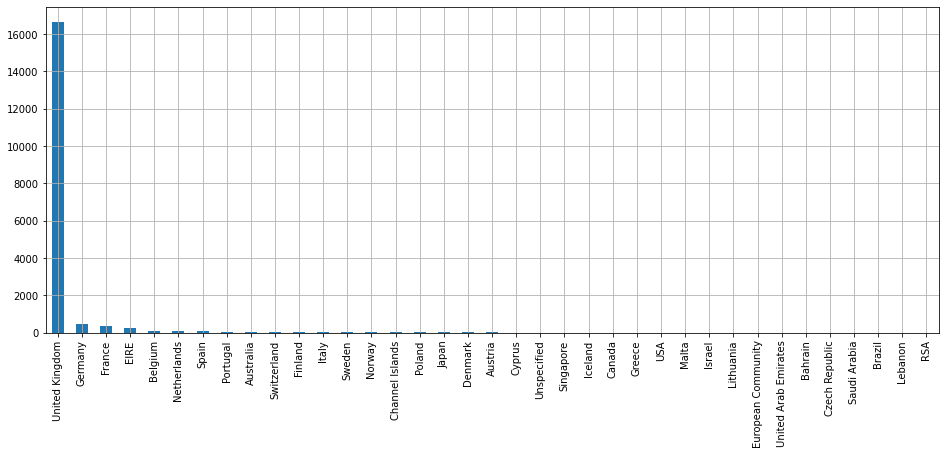

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
# Use a dataframe where only one entry is picked for each invoice
dfinvgb = df[["Invoice", "Country"]].drop_duplicates()
plt.figure(figsize=(16, 6))
# Turn on the grid
dfinvgb["Country"].value_counts().plot.bar(grid = True)

### Limit to UK customers 

In [19]:
df = df[df["Country"].str.contains('United Kingdom')]

### List the counts of customer origin in the invoices

In [20]:
dfinvgb["Country"].value_counts()

United Kingdom          16635
Germany                   457
France                    389
EIRE                      260
Belgium                    98
Netherlands                94
Spain                      90
Portugal                   57
Australia                  57
Switzerland                51
Finland                    41
Italy                      38
Sweden                     36
Norway                     36
Channel Islands            26
Poland                     19
Japan                      19
Denmark                    18
Austria                    17
Cyprus                     16
Unspecified                 8
Singapore                   7
Iceland                     7
Canada                      6
Greece                      5
USA                         5
Malta                       5
Israel                      5
Lithuania                   4
European Community          4
United Arab Emirates        3
Bahrain                     2
Czech Republic              2
Saudi Arab

### Diversity in Customer Purchasing Habbits

Analysis of the purchase data reveals that there is diversity in the purchasing behavior of customers who shop at the store. This will be illustrated by capturing the patterns in store visits.

### Number of Customer Visits to the Store

The Recency-Frequency-Monetary Value is an idea used in the retail domain to analyze customers. See [this article](https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17) for more details. This idea will be used later in this work. For now, the relevant fact is that the number of customer visits to the store is an important metric in the analysis of retail data. Since we are in an online setting, the number of store visits is approximated as the number of invoices the customer generates at the store. The number of customer visits can be obtained by grouping by customer ID and then counting the number of unique invoices for the customer

In [21]:
df_ciph = df.groupby(["Customer ID"]).agg({'Invoice':['nunique']}).reset_index()
df_ciph.columns = df_ciph.columns.map(''.join)
df_ciph = df_ciph.sort_values(by = "Invoicenunique", ascending = False)
df_ciph.columns = ["Customer ID", "num_invoices"]

### Observations about customer store visits

1. A histogram of customer visits to the store is shown below. A review of this histogram shows that most customers make a small number of store visits, however there are customers that make many visits to the store. Some even make hundreds of store visits. One explanation for this behavior is that store has both retail and wholesale customers. Later in this illustration, a threshold will be used to demarcate wholesale versus the retail customer.
2. The quartiles of customer store visit attribute are also shown below. The median number of store visits by a customer is 2. For this analysis, we will consider customers making more than 5 visits to the store as frequent customers.
3. In summary, we can broadly divide the store customers into the following categories:
  1. Wholesale Customers
  2. Frequent Customers (retail)
  3. Infrequent Customers (possibly new, retail)


### Note:
This work will focus of the purchasing behavior of frequent customers. These are customers who make 5 or more visits to the store. Customers who make less than 5 visits to the store are considered customers with insufficient purchase history at the store for this analysis.

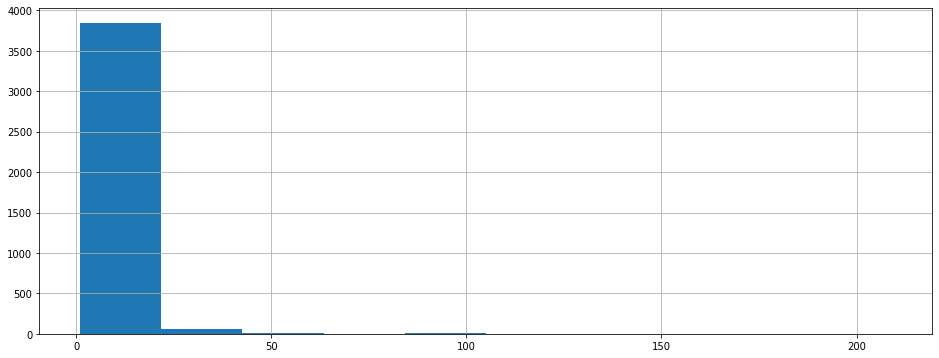

In [22]:
plt.figure(figsize=(16, 6))
df_ciph["num_invoices"].hist()

In [23]:
df_ciph["num_invoices"].quantile(q = [0.2, 0.4, 0.5, 0.8, 0.9, 0.95])

0.20     1.0
0.40     2.0
0.50     2.0
0.80     6.0
0.90     9.0
0.95    13.0
Name: num_invoices, dtype: float64

### Observations about Item Prices at the store
Most items at the store are cheap. The median price of an item is less than 2 pounds. The summary of the _Price_ attribute is shown below

In [24]:
df["Price"].describe()

count    354309.000000
mean          2.963628
std          17.862831
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: Price, dtype: float64

### Invoice Line Item Purchase Value
As discussed in the observations about the number of customer visits, the store has both retail and whole sale customers. Going with a definition of a whole customer as one who purchases a lot of a particular store item, we will use a threshold value of _ItemTotal_ to capture invoices that are associated with whole sale purchases. Most store items are cheap, with the median value being less than 2 pounds. We will use the $95^{th}$ percentile of this attribute as a threshold value to capture a whole sale purchase.

### Remove wholesale customers

In [25]:
ITEM_TOTAL_95_LVL = df["ItemTotal"].quantile(q = [0.95]).iloc[0]
df_ws = df.query("ItemTotal >= @ITEM_TOTAL_95_LVL")
ws_invoices = df_ws["Invoice"].tolist()
df = df[-df["Invoice"].isin(ws_invoices)]

### Remove customers with low purchase history (retain only frequent shoppers)

In [26]:
df_ciph = df.groupby(["Customer ID"]).agg({'Invoice':['nunique']}).reset_index()
df_ciph.columns = df_ciph.columns.map(''.join)
df_ciph = df_ciph.sort_values(by = "Invoicenunique", ascending = False)
df_ciph.columns = ["Customer ID", "num_invoices"]
INSUFF_PURCHASE_HISTORY_LVL = 5
df_ciph = df_ciph.query("num_invoices < @INSUFF_PURCHASE_HISTORY_LVL")
insuff_purch_hist = df_ciph["Customer ID"].tolist()
df = df[-df["Customer ID"].isin(insuff_purch_hist)]

### Customer Populations
In this work, we will be analyzing the group of customers who make frequent purchases at the store. By analyzing the whole sale customers and the infrequent shopper group, also using graph analytic techniques, we can generate a comprehensive profile of the customers visiting the store.

## User Utility Matrix Computation

A common data representation of customer purchasing habbits used in retail applications is one where each user is represented by his purchases of the various items at the store. Such a representation has a tabular structure where each user is a row in the table. This representation is called the _user-item utility matrix_ . The columns represent the aggregate purchases of the various items at the store. The __Recency_Frequency_Monetary Value__ concept is used to capture the value of a user. Therefore, in addition to the purchases. These attributes are captured as well. The _Recency_ attribute captures the time from a reference data since the user's last visit. The _Frequency_ attribute captures the number of visits made by the customer to the store. The _Monetary Value_ captures the customer's cumulative spend at the store. A schematic illustrating the _user-item utility matrix_ is shown below. The details of computation of this matrix follow.

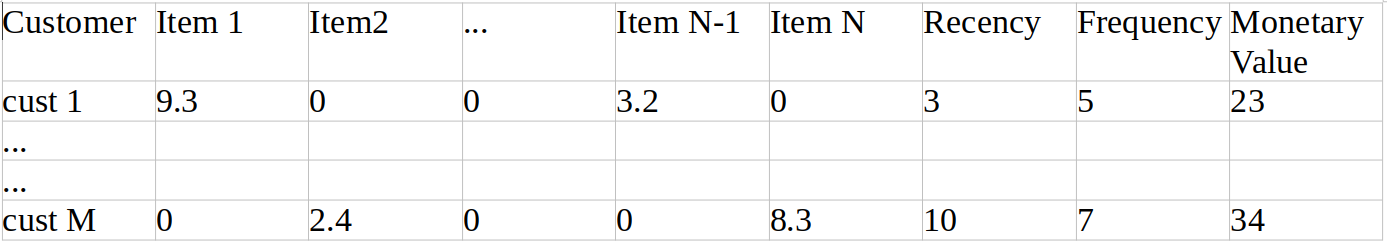

In [27]:
Image('img/user_item_matrix_schematic.png')

![](./figures/user_item_matrix_schematic.png)

The _user-item utility matrix_ can be computed from the data using the _pivot-table_ construct with the customer as the index column and the sum applied to the _ItemTotal_ attribute. The details of the computation are shown below. The default implementation puts NaN values for items where the user has not made a purchase. These are filled out as zeros

### User Item Interaction
To understand the nature of a customers interaction with store items, let us compute the number of items a customer interacts with over a lifetime of purchases at the store. The summary statistics of this attribute is shown below. As is evident, the median value for the interaction is about 110 items.

In [28]:
df_item_cust = df.groupby(["Customer ID"]).agg({'StockCode':['nunique']}).reset_index()
df_item_cust.columns = df_item_cust.columns.map(''.join)
df_item_cust = df_item_cust.sort_values(by = "StockCodenunique", ascending = False)
df_item_cust.columns = ["Customer ID", "num_item_types_purchased"]
df_item_cust["num_item_types_purchased"].quantile(q = [0.2, 0.4, 0.5, 0.8, 0.9, 0.95])

0.20     64.0
0.40     97.0
0.50    110.0
0.80    191.8
0.90    273.6
0.95    323.8
Name: num_item_types_purchased, dtype: float64

In [29]:
import numpy as np
df_customer_summary = df.groupby(["Customer ID", "StockCode"]).\
agg({'ItemTotal':['sum']}).reset_index()
df_customer_summary.columns = df_customer_summary.columns.map(''.join)
df_customer_report  = df_customer_summary.pivot(index='Customer ID', columns='StockCode', values='ItemTotalsum')
df_customer_report = df_customer_report.fillna(0)

## Feature Selection with Linear Models

One of the objectives for this work is to understand the frequent shopper groups preferences for store items. An intrinsic feature of the user-item utility matrix is that a user is a high-dimensional representation. The frequent shopper group purchases  2765  store items. The median value of items a customer purchases at the store is  110 . The dimensionality on the other hand is  2765 . This implies that for most customers, the representation is going to have a high proportion of zero values. Such a representation is called a sparse representation. Since one of the objectives of this work is to understand the nature of customer shopping preferences, a feature selection model based on a linear regression model is used to identify the pool of store items that can capture the customer value at the store. The details of developing this model are provided in the next set of illustration. In developing the data representation of the customer, a data preparation step in light of this downstream modeling activity is relavant. This step pertains to removing correlated attributes from the customer representation. Linear models are affected by a phenomenon called multi-collinearity, a condition that manifests when we have attributes that are highly correlated with each other. Multi-collinearity presents computational difficulties in estimating linear models. To prevent multi-collinearity, when we have highly correlated columns, we retain one of the columns and drop the other. In this work a threshold of  0.8  is used to screen the correlated columns in the user-item utility matrix. The details of removing the correlated items are shown below.

In [30]:
dfsclu = df[["StockCode", "Description"]].drop_duplicates()
print("Computing correlations...")
df_corr = df_customer_report.corr()
cols = df_corr.columns.tolist()
high_corr = dict()
THRESHOLD_CORR = 0.8

for index, row in df_corr.iterrows():
    for c in cols:
        if (row[c] > THRESHOLD_CORR) and (index != c):
            if not (c, index) in high_corr:
                high_corr[(index, c)] = row[c]

drop_cols = []
print("Creating the list of columns to drop on the basis of high correlation...")
for k, v in high_corr.items():
    drop_cols.append(k[1])

print("Creating a description of highly correlated columns for analysis...")
hc_df_dict = {'var_1': [], 'desc_1': [], 'var_2': [], 'desc_2': [], 'corr':[]}
for k, v in high_corr.items():
    hc_df_dict["var_1"].append(k[0])
    trimstr = dfsclu.loc[dfsclu["StockCode"] == k[0]]["Description"].values[0]
    trimstr = trimstr.replace(" ", "_")
    hc_df_dict["desc_1"].append(trimstr)
    hc_df_dict["var_2"].append(k[1])
    trimstr = dfsclu.loc[dfsclu["StockCode"] == k[1]]["Description"].values[0]
    trimstr = trimstr.replace(" ", "_")
    hc_df_dict["desc_2"].append(trimstr)
    hc_df_dict["corr"].append(v)

df_high_corr_var = pd.DataFrame.from_dict(hc_df_dict, orient='index').T
fp_hci = "data/highly_correlated_items.csv"
df_high_corr_var.to_csv(fp_hci, index = False)
print("Removing the list of highly correlated columns...")
cols = df_customer_report.columns.tolist()
ucol = [c for c in cols if c not in drop_cols]
df_customer_report = df_customer_report[ucol]
print("Done!")

Computing correlations...
Creating the list of columns to drop on the basis of high correlation...
Creating a description of highly correlated columns for analysis...
Removing the list of highly correlated columns...
Done!


## Recency, Frequency and Monetary-Value computation

The details of computing the __recency__, __frequency__ and __monetary value__ attributes for the customer are shown below. 
1. _recency_: The _recency_ attribute captures the time that has elapsed since the customer's last visit to the store. To compute this, the first date in the data is used as a reference date. The time period that has elapsed between the customer's last visit to the store, as available from the customer's newest invoice,  and this reference date is captured as a measure of customer's store visit recency.
2. _frequency_: The _frequency_ attribute captures the number of purchases the customer has made at the store. This directly maps to the number of invoices generated by the customer, so computing this attribute translates to simply counting the number of invoices for the customer.
3. _monetary value_: The _monetary value_ captures the amount of money the customer has spent at the store. This can be computed by aggregating the invoice line item totals for all the customer's invoices. 

Computing these attributes can be performed easily with the _groupby_ and _agg_ functions available in _pandas_. The details of the computation are shown below.

In [31]:
import numpy as np
ref_date = df["InvoiceDate"].max() + pd.DateOffset(days=1)
dfcustlv = df.groupby(["Customer ID"]).agg({'InvoiceDate':['max']}).reset_index()
dfcustlv.columns = dfcustlv.columns.map(''.join)
dfcustlv.columns = ["Customer ID", "last_visit_date"]
dfcustlv = dfcustlv.set_index("Customer ID")
dfcustlv["recency"] = (ref_date - dfcustlv["last_visit_date"])/np.timedelta64(1,'D')
dfcustlv = dfcustlv["recency"]
dfcustlv.columns = ["recency"]

df_freq = df.groupby(["Customer ID"]).agg({'Invoice':['nunique']}).reset_index()
df_freq.columns = df_freq.columns.map(''.join)
df_freq = df_freq.set_index("Customer ID")
df_freq.columns = ["freq"]

dfum = df.groupby(["Customer ID"]).agg({'ItemTotal' :['sum']}).reset_index()
dfum.columns = dfum.columns.map(''.join)
dfum.columns = ["Customer ID", "MonetaryValue"]
dfum = dfum.set_index("Customer ID")

In [32]:
df_customer_report = pd.concat([df_customer_report, dfum], axis = 1)
df_customer_report = pd.concat([df_customer_report, df_freq], axis = 1)
df_customer_report = pd.concat([df_customer_report, dfcustlv], axis = 1)
#HIGH_VALUE_CUST_LVL = df_customer_report["MonetaryValue"].quantile(q = [0.95]).values[0]
#df_customer_report = df_customer_report.query("MonetaryValue <= @HIGH_VALUE_CUST_LVL")
print ("Writing data file...")
fp = "data/user_item_utility_matrix.csv"
df_customer_report.to_csv(fp)
print("Done!")

Writing data file...
Done!


# Log Model Building Meta-Data with Arangopipe
Arangopipe is a tool to capture meta-data from data science project activities. See the [the project repository](https://github.com/arangoml/arangopipe) for more details. See [this notebook](https://github.com/arangoml/arangopipe/blob/master/examples/Arangopipe_Feature_Examples.ipynb) for an overview of the basic steps involved in capturing datascience project activity meta-data with Arangopipe. The cells below capture the meta-data from the exploratory data analysis task with Arangopipe.

###  Create an Arangopipe Project

In [33]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arangoml.arangodb.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


2021-04-16 10:06:48,829 - arangopipe_admin_logger - ERROR - Error connecting to DB, trying again...


API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arangoml.arangodb.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


2021-04-16 10:07:13,898 - arangopipe_admin_logger - ERROR - Obtained connection with retry!


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': None,
  'conn_protocol': 'https',
  'dbName': 'MLuzaw9zomlzp5qtbqclgja3',
  'password': 'MLwqe8xcb3yam2h9mfrd05',
  'username': 'ML7vusoggqczoyyrkr7a08x'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

### Register Dataset

In [34]:
ds_info = {"name" : "retail analytics dataset",\
            "description": "This dataset lists details of invoices generated at an online store selling gift items in the UK",\
           "source": "UCI ML Repository" }
ds_reg = ap.register_dataset(ds_info)

### Register the Featureset

In [35]:

import numpy as np
featureset = df.dtypes.to_dict()
featureset = {k:str(featureset[k]) for k in featureset}
featureset["name"] = "retail analytics feature setl"
fs_reg = ap.register_featureset(featureset, ds_reg["_key"]) # note that the dataset and featureset are linked here.

### Register this Exploratory Data Analysis Task with Arangopipe

In [36]:
model_info = {"name": "Exploratory Data Analysis, phase I",  "task": "EDA"}
model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

### Log Exploratory Data Analysis Task with Arangopipe

In [37]:
import uuid
import datetime
import jsonpickle

ruuid = str(uuid.uuid4().int)
qme = jsonpickle.encode(dqm)
model_perf = {'run_id': ruuid, 'quality_metrics': qme, "timestamp": str(datetime.datetime.now())}

model_params = {'run_id': ruuid, 'model_params': 'NA'}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Retail_Graph_Analytics",\
                    "project": "Retail_Graph_Analytics"}
ap.log_run(run_info)